In [1]:
import numpy as np
import h5py as h5

import scipy as scp
import sklearn as skl
import matplotlib.pyplot as plt
import keras 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from skimage.measure import block_reduce

from keras.models import Sequential, Model
from keras.layers import Dense, GaussianNoise, Input, Conv2D, Flatten, MaxPooling2D, Dropout, Conv2DTranspose, Reshape
from keras.regularizers import l2

from mlhelpers4 import PlotLosses, plot_a_bunch_of_beams,make_dataset
plot_losses=PlotLosses()
from sklearn.preprocessing import MinMaxScaler
plt.rcParams.update({'font.size': 10})
#plt.style.use('rs_paper.mplstyle')
import time

## Data Cleaning

Read in the appropriate dataset, handle the image size downsampling if necessary, and rescale everything to one.

In [2]:
############# set these according to which offsets you want to run. 
############# If the file does not exist, you'll need to go run it in SRW_multiprocess.py 
offsets_mirror1 = True
offsets_mirror2 = True
rotations_mirror1 = True 
rotations_mirror2 = True
n_runs = 10000

input_str = 'datasets/beam_intensities_'
output_str = 'datasets/parameters_'
save_str = 'results/'
data_str = '' 
if offsets_mirror1:
    save_str += 'mirror1_offsets_'
    data_str += 'mirror1_offsets_'

if offsets_mirror2:
    save_str += 'mirror2_offsets_'
    data_str += 'mirror2_offsets_'

if rotations_mirror1:
    save_str += 'mirror1_rotations_'
    data_str += 'mirror1_rotations_'

if rotations_mirror2: 
    save_str += 'mirror2_rotations_'
    data_str += 'mirror2_rotations_'
    
inputs = np.load(input_str + data_str + str(n_runs) + 'runs.npy')#[:2000,:,:]
outputs = np.load(output_str + data_str + str(n_runs) + 'runs.npy').reshape(n_runs, -1)#[:2000,:]
n_points = inputs.shape[0]
image_shape = inputs.shape[1:]
print(inputs.shape)
print(outputs.shape)

(10000, 280, 280)
(10000, 6)


### Reduce the Image Size

The raw data images are 280 x 280, which means a lot of pixels with zero information in them. We try downsampling the images to be smaller to make the training a bit faster.

In [3]:
block_size = 8
new_im = block_reduce(inputs, block_size=(1,block_size, block_size), func=np.mean)
new_im /= np.amax(new_im)
print('new data shape = {}'.format(new_im.shape))
image_shape = new_im.shape[1:]

new data shape = (10000, 35, 35)


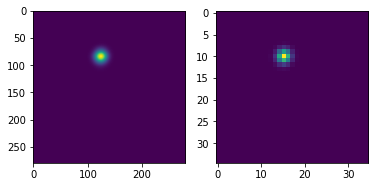

In [4]:
fig, [ax1, ax2] = plt.subplots(1,2)
ax1.imshow(inputs[0])
ax2.imshow(new_im[0])

In [5]:
############# sets labels for automated plots for results 
labels = []
if offsets_mirror1:
    labels.append('dx1')

if offsets_mirror2:
    labels.append('dy2')

if rotations_mirror1: 
    #labels.append('thetax1')
    labels.append('thetay1')
    labels.append('thetaz1')
    
if rotations_mirror2: 
    labels.append('thetax2')
    #labels.append('thetay2')
    labels.append('thetaz2')

print(labels)
print(save_str)

['dx1', 'dy2', 'thetay1', 'thetaz1', 'thetax2', 'thetaz2']
results/mirror1_offsets_mirror2_offsets_mirror1_rotations_mirror2_rotations_


In [6]:
############# normalize beam inputs 
max_val = np.max(new_im)
print(max_val)
inputs_norm = new_im / max_val

1.0


In [7]:
############# normalize parameter offsets 
transformer_y = RobustScaler().fit(outputs)
Y_scaled = transformer_y.transform(outputs)
print(np.max(Y_scaled))
print(np.min(Y_scaled))

1.0068269630417783
-1.0067199539492877


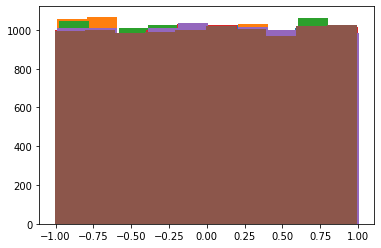

In [8]:
############# beautiful plot to make sure you actually normalized everything 
for i in range(Y_scaled.shape[1]):
    plt.hist(Y_scaled[:, i])
plt.show()

In [9]:
############# split train/test data 
split = 80
print(np.shape(inputs_norm))
reshaped_norm = inputs_norm.reshape(inputs_norm.shape[0], inputs_norm.shape[1]*inputs_norm.shape[2])
y_train, y_val, x_train, x_val = train_test_split(reshaped_norm, Y_scaled, 
                                                test_size = (100 - split) / 100.,
                                                random_state = 42) 

#y_train = y_train.reshape(y_train.shape[0],y_train.shape[1], y_train.shape[2],1)
#y_val = y_val.reshape(y_val.shape[0],y_val.shape[1], y_val.shape[2],1)

(10000, 35, 35)


In [10]:
print(x_train.shape)
print(x_val.shape)
print(np.shape(y_val))

(8000, 6)
(2000, 6)
(2000, 1225)


## Model

### Model Hyperparameters

In [11]:
# layers
layer_size = [20, 50, 100, 200, 400]
layer_type = ['relu', 'relu', 'relu', 'relu', 'relu']

# check that we didn't mess this up
assert len(layer_size) == len(layer_type)

# gaussian noise regularization
noise_level = .1

In [12]:
model = Sequential() ## initial feed forward model 

# add the input layer
model.add(Dense(x_train.shape[1], 
                activation='linear', 
                input_dim=x_train.shape[1]))

for idx, size in enumerate(layer_size):
    model.add(Dense(size, 
                    activation=layer_type[idx],
                    kernel_regularizer=l2(l=0.00001)))
    #model.add(GaussianNoise(noise_level))
    
# add the output layer
model.add(Dense(y_train.shape[1], 
                activation='relu'))

opt = keras.optimizers.Adam()
    
model.compile(optimizer=opt, loss='mean_squared_error') ## setup the optimizer and loss function
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6)                 42        
_________________________________________________________________
dense_1 (Dense)              (None, 20)                140       
_________________________________________________________________
dense_2 (Dense)              (None, 50)                1050      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               5100      
_________________________________________________________________
dense_4 (Dense)              (None, 200)               20200     
_________________________________________________________________
dense_5 (Dense)              (None, 400)               80400     
_________________________________________________________________
dense_6 (Dense)              (None, 1225)              4

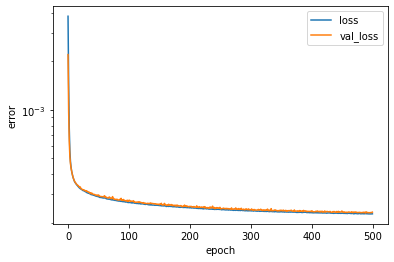

Time to train model: 15.57270214955012 minutes


In [13]:
n_epochs = 500
start = time.time()
hist = model.fit(x=x_train, y=y_train, 
                validation_data= (x_val, y_val),
                 batch_size = 128,
                 shuffle = 'true',
                 epochs = n_epochs,
                 verbose = 'false',
                 callbacks = [plot_losses])
end = time.time()
print('Time to train model: ' + str((end - start)/60) + ' minutes')


In [14]:
model.save_weights(str(save_str) + 'n_epochs_' + str(n_epochs) + '_conv' '.h5')

### Load trained model weights

start = time.time()
model.load_weights('small_model_weights.h5')
pred_outputs = model.predict(x_val)
end = time.time()
print('Time to load model and get new predictions: ' + str(np.round((end - start)/60, 5)) + ' minutes')

### Plot logloss 

In [15]:
'''
plt.figure()
plt.loglog(hist.epoch, hist.history['val_loss'])
plt.loglog(hist.epoch, hist.history['loss'])
plt.show()
'''

"\nplt.figure()\nplt.loglog(hist.epoch, hist.history['val_loss'])\nplt.loglog(hist.epoch, hist.history['loss'])\nplt.show()\n"

### Plot loss 

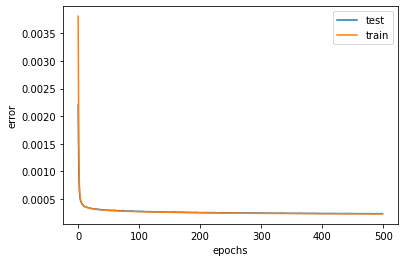

In [16]:
plt.figure()
plt.ylabel('error')
plt.xlabel('epochs')
plt.plot(hist.epoch, hist.history['val_loss'], label='test')
plt.plot(hist.epoch, hist.history['loss'], label='train')
plt.legend(loc='best')
plt.savefig(save_str + 'lossplot.png')
plt.show()

# Eval Model

In [17]:
pred_outputs = model.predict(x_val)
n_outputs = pred_outputs.shape[1]
errs = np.sum((pred_outputs - y_val)**2, axis=1)
print(np.shape(errs))

(2000,)


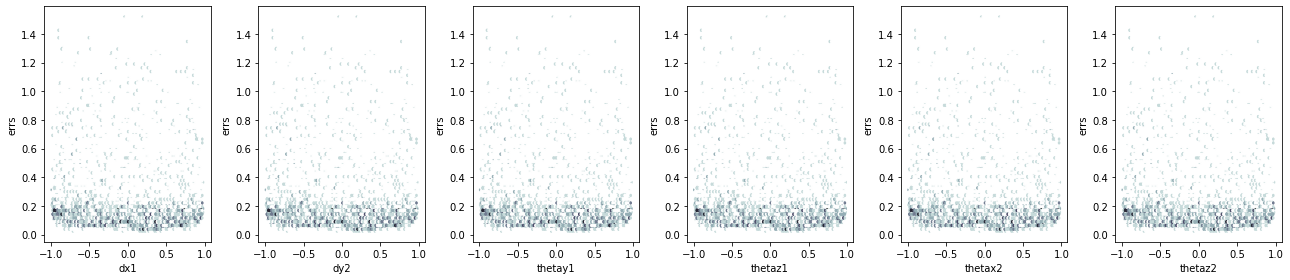

In [18]:
fig, axs = plt.subplots(1, len(labels), figsize=(18,4))
for idx, label in enumerate(labels):

    axs[idx].hexbin(x_val[:,0], errs, cmap = 'bone_r')
    axs[idx].set_xlabel(label)
    axs[idx].set_ylabel('errs')
fig.tight_layout()

### Look at some of the predictions

In [19]:
idxes = np.random.randint(0, 200, size=(5,))

In [20]:
preds = model.predict(x_val[idxes])
preds = preds.reshape(preds.shape[0], image_shape[0], image_shape[1])


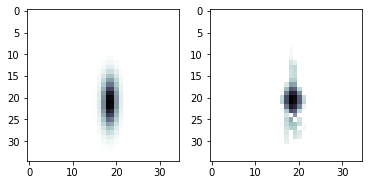

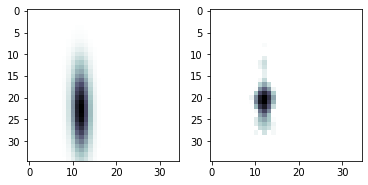

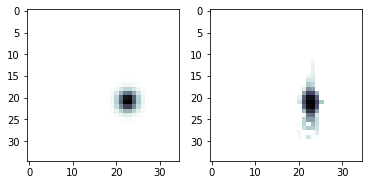

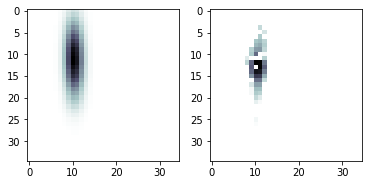

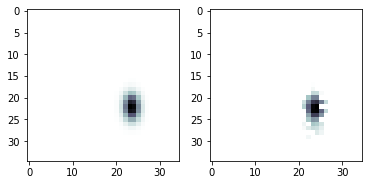

In [21]:
for idx, example in enumerate(idxes):
    fig, [ax1, ax2] = plt.subplots(1,2)
    ax1.imshow(y_val[example].reshape(image_shape[0], image_shape[1]), cmap='bone_r')
    ax2.imshow(preds[idx], cmap='bone_r')

### Training Set Predictions

Did this train well on the training set?

In [22]:
idxes = np.random.randint(0, 200, size=(5,))

In [23]:
preds = model.predict(x_train[idxes])
preds = preds.reshape(preds.shape[0], image_shape[0], image_shape[1])


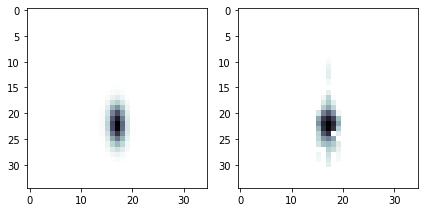

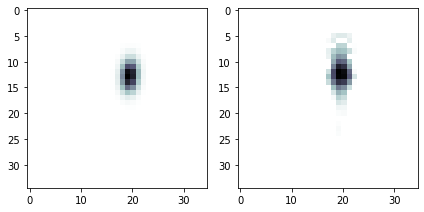

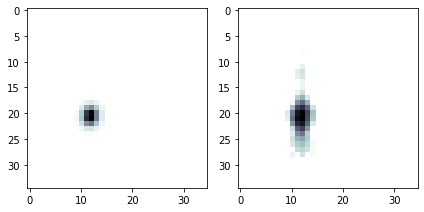

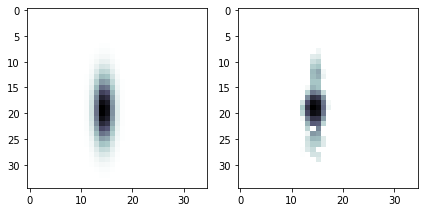

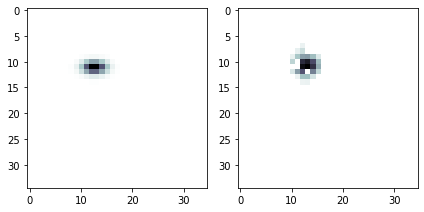

In [24]:
for idx, example in enumerate(idxes):
    fig, [ax1, ax2] = plt.subplots(1,2)
    training_data = y_train[example].reshape(image_shape[0], image_shape[1])
    ax1.imshow(training_data, cmap='bone_r')
    ax2.imshow(preds[idx], cmap='bone_r')
    #err = ax3.imshow(preds[idx] - training_data, cmap='bone_r')
#    fig.colorbar(err)
    fig.tight_layout()